<a href="https://colab.research.google.com/github/acuasami/Protocolo-/blob/main/prueba_A_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Instalación de Dependencias

In [ ]:
# instala dependencias del sistema (necesarias para geopandas, rtree, etc.)
!apt-get update -qq && apt-get install -y -qq libspatialindex-dev

# instala OSMnx y dependencias clave
!pip install -q osmnx networkx geopandas folium

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libspatialindex6:amd64.
(Reading database ... 126374 files and directories currently installed.)
Preparing to unpack .../libspatialindex6_1.9.3-2_amd64.deb ...
Unpacking libspatialindex6:amd64 (1.9.3-2) ...
Selecting previously unselected package libspatialindex-c6:amd64.
Preparing to unpack .../libspatialindex-c6_1.9.3-2_amd64.deb ...
Unpacking libspatialindex-c6:amd64 (1.9.3-2) ...
Selecting previously unselected package libspatialindex-dev:amd64.
Preparing to unpack .../libspatialindex-dev_1.9.3-2_amd64.deb ...
Unpacking libspatialindex-dev:amd64 (1.9.3-2) ...
Setting up libspatialindex6:amd64 (1.9.3-2) ...
Setting up libspatialindex-c6:amd64 (1.9.3-2) ...
Setting up libspatialindex-dev:amd64 (1.9.3-2) ...
Processing triggers for libc-bin (2.35-0ubuntu3.8) .

2. Configuración Inicial e Importación de Bibliotecas

In [ ]:
import osmnx as ox
import networkx as nx
from math import radians, sin, cos, sqrt, asin, atan2
import heapq
import folium

# Opcional: configura el log de OSMnx para menos verbosidad
ox.settings.log_console = False

3. Descarga de la Red Vial

In [ ]:
# Descarga la red vial (a pie) de un área de ejemplo
G = ox.graph_from_place("Guadalajara, Mexico", network_type="walk")

4. Función de Distancia Haversine

In [ ]:
def haversine(u, v, coords_dict):
    """Distancia ortodrómica en metros entre nodos u y v usando diccionario precalculado."""
    # 1. Extraer coordenadas del diccionario (acceso O(1))
    lat1, lon1 = coords_dict[u]  # Latitud y longitud del nodo u
    lat2, lon2 = coords_dict[v]  # Latitud y longitud del nodo v

    # 2. Convertir todas las coordenadas de grados a radianes
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # 3. Calcular diferencias de coordenadas
    dlat = lat2 - lat1  # Diferencia de latitudes
    dlon = lon2 - lon1  # Diferencia de longitudes

    # 4. Aplicar fórmula de Haversine:
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2

    # 5. Calcular y retornar distancia final:
    return 2 * 6371000 * asin(sqrt(a))  # 6371000 = radio terrestre en metros

5. Implementación del Algoritmo A*

In [ ]:
def astar(graph, start, goal, h, weight='length'):
    """Retorna lista de nodos desde start hasta goal."""
    # 1. Inicialización:
    #    - Cola de prioridad (heap) con tuplas (f_score, nodo)
    #    - Comienza con el nodo inicial y f_score = 0
    open_set = [(0, start)]

    # 2. Diccionario para reconstruir caminos (padres de cada nodo)
    came_from = {}

    # 3. Diccionario de costos reales desde el inicio (g_scores)
    #    - El costo para el nodo inicial es 0
    gscore = {start: 0}

    # 4. Bucle principal: se ejecuta mientras haya nodos por explorar
    while open_set:
        # 5. Extraer el nodo con MENOR f_score de la cola de prioridad
        f, u = heapq.heappop(open_set)

        # 6. Si llegamos al objetivo, reconstruir y retornar el camino
        if u == goal:
            # Reconstrucción inversa del camino:
            path = []
            # 7. Retroceder desde el objetivo hasta el inicio
            while u in came_from:
                path.append(u)
                u = came_from[u]  # Subir al nodo padre
            # 8. Invertir el camino y agregar el nodo inicial
            return [start] + path[::-1]

        # 9. Explorar vecinos del nodo actual (u)
        for v, data in graph[u].items():
            # 10. Obtener peso de la arista (u->v)
            #     - Por defecto usa 'length' pero puede ser otro atributo
            w = data.get(weight, 1)

            # 11. Calcular costo tentativo desde inicio hasta v
            tentative_g = gscore[u] + w

            # 12. Si encontramos un camino MEJOR hacia v:
            if tentative_g < gscore.get(v, float('inf')):
                # 13. Actualizar el padre de v
                came_from[v] = u

                # 14. Actualizar g_score (costo real desde inicio)
                gscore[v] = tentative_g

                # 15. Calcular f_score = costo real + heurística
                fscore = tentative_g + h(v, goal)

                # 16. Agregar vecino a la cola de prioridad
                heapq.heappush(open_set, (fscore, v))

    # 17. Si no se encuentra camino, retornar None
    return None

6. Precalcula un diccionario global de coordenadas para acceso rápido durante el algoritmo

In [ ]:
# PRIMERO: Crear diccionario de coordenadas (ANTES de usar A*)
node_coords = {node: (data['y'], data['x']) for node, data in G.nodes(data=True)}

7. Convierte coordenadas geográficas a nodos del grafo

In [ ]:
# Obtener los nodos más cercanos (igual que antes)
origin_node = ox.distance.nearest_nodes(G, orig_point[0], orig_point[1])
dest_node = ox.distance.nearest_nodes(G, dest_point[0], dest_point[1])

8. Obtiene datos PRECALCULADOS

In [ ]:
# Obtener coordenadas de los nodos (AHORA usando node_coords)
origin_coords = node_coords[origin_node]  # (lat, lon)
dest_coords = node_coords[dest_node]      # (lat, lon)

9. Busca el camino óptimo usando A* con función heurística acelerada

In [ ]:
print("\nNodo de origen:")
print(f"ID: {origin_node}")
print(f"Coordenadas: {origin_coords}")

print("\nNodo de destino:")
print(f"ID: {dest_node}")
print(f"Coordenadas: {dest_coords}")

# Ejecutar A* (CAMBIAR la función heurística)
route_custom = astar(
    G,
    origin_node,
    dest_node,
    h=lambda u, v: haversine(u, v, node_coords),  # Usar diccionario, no G
    weight='length'
)

print("\nRuta encontrada:", route_custom)


Nodo de origen:
ID: 1455591383
Coordenadas: (20.6053819, -103.3877363)

Nodo de destino:
ID: 1455591383
Coordenadas: (20.6053819, -103.3877363)

Ruta encontrada: [1455591383]


7. Ejemplo con A* de NetworkX


Nodo origen: 1366885211
Nodo destino: 1597309217

Ruta encontrada con 47 nodos


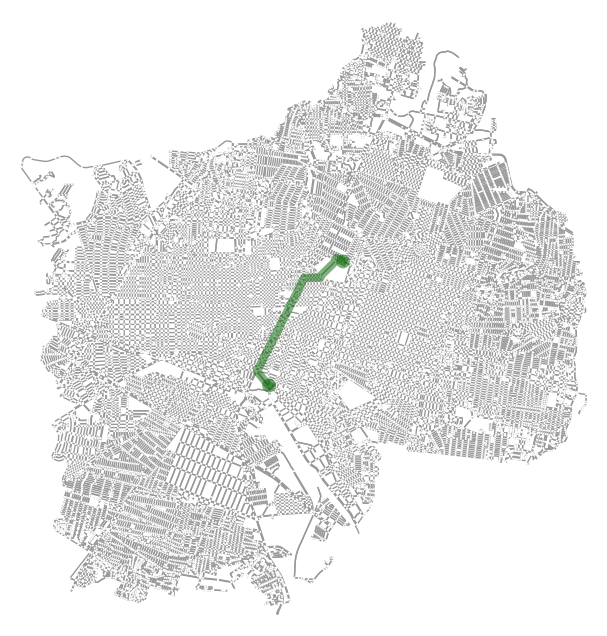

In [ ]:
# 1. Configuración inicial de OSMnx
ox.settings.log_console = True    # Habilita logs en consola
ox.settings.use_cache = True       # Usa caché para evitar descargas repetidas

# 5. Definición de puntos geográficos (lat, lon)
orig_point = (20.659526349070514, -103.34578170524541)  # Origen
dest_point = (20.687168991288143, -103.3269264152452)   # Destino


print(f"\nNodo origen: {origin_node}")
print(f"Nodo destino: {dest_node}")

# 7. Búsqueda de ruta con A* optimizado
try:
    # Uso de heurística con diccionario precalculado
    route_custom = nx.astar_path(
        G,
        origin_node,
        dest_node,
        heuristic=lambda u, v: haversine(u, v, node_coords),  # Optimizado
        weight='length'  # Usa longitud física de aristas
    )
    print(f"\nRuta encontrada con {len(route_custom)} nodos")

    # 8. Visualización del resultado
    fig, ax = ox.plot_graph_route(
        G,
        route_custom,
        route_linewidth=6,
        route_color='darkgreen',  # Color de la ruta
        node_size=2,             # Tamaño de nodos reducido
        bgcolor='white'          # Fondo blanco
    )

except nx.NetworkXNoPath:
    # Manejo de error: ruta inexistente
    print("\n¡Error! No se encontró ruta entre los puntos")
    fig, ax = ox.plot_graph(G, node_size=2)
    # Marcadores de ubicaciones
    ax.scatter(orig_point[1], orig_point[0], c='red', s=100, zorder=3)
    ax.scatter(dest_point[1], dest_point[0], c='blue', s=100, zorder=3)

In [ ]:
# Correcto: (lon, lat)
origin_node = ox.nearest_nodes(G, orig_point[1], orig_point[0])

In [ ]:
# 7. Obtener coordenadas de los nodos de la ruta
route_coords = []
for node in route_custom:
    node_data = G.nodes[node]
    route_coords.append((node_data['y'], node_data['x']))  # (lat, lon)

# 8. Crear mapa de Folium
map_center = [
    (orig_point[0] + dest_point[0])/2,
    (orig_point[1] + dest_point[1])/2
]

m = folium.Map(
    location=map_center,
    zoom_start=14,
    tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
)

# 9. Añadir marcadores
folium.Marker(
    location=orig_point,
    popup='<b>Origen</b>',
    icon=folium.Icon(color='green', icon='flag')
).add_to(m)

folium.Marker(
    location=dest_point,
    popup='<b>Destino</b>',
    icon=folium.Icon(color='red', icon='flag')
).add_to(m)

# 10. Añadir ruta
folium.PolyLine(
    locations=route_coords,
    color='blue',
    weight=5,
    opacity=0.7,
    popup='Ruta A*',
    smooth_factor=1
).add_to(m)

# 11. Añadir nodos de inicio y fin de ruta
folium.CircleMarker(
    location=route_coords[0],
    radius=6,
    color='darkgreen',
    fill=True,
    fill_color='green',
    popup=f'Nodo inicio: {origin_node}'
).add_to(m)

folium.CircleMarker(
    location=route_coords[-1],
    radius=6,
    color='darkred',
    fill=True,
    fill_color='red',
    popup=f'Nodo fin: {dest_node}'
).add_to(m)

# 12. Mostrar mapa
m.save('ruta_guadalajara.html')
m